DATA PREPROCESSING

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('kag_risk_factors_cervical_cancer.csv')

In [3]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col],errors='coerce')
df = df.fillna(df.mean().iloc[0])
df = df.drop(columns=['STDs:cervical condylomatosis','STDs:vaginal condylomatosis','STDs:vulvo-perineal condylomatosis','STDs:syphilis','STDs:pelvic inflammatory disease','STDs:genital herpes','STDs:AIDS','STDs:Hepatitis B','STDs:HPV','STDs:molluscum contagiosum'])
#df = df.drop(columns=['STDs:cervical condylomatosis','STDs:vaginal condylomatosis','STDs:vulvo-perineal condylomatosis','STDs:pelvic inflammatory disease','STDs:genital herpes','STDs:Hepatitis B','STDs:HPV','Dx:CIN','Dx:HPV','Dx','STDs:molluscum contagiosum'])

Removing OUTLIERS


In [4]:
one = df.iloc[:, -4:].any(axis=1) #check if any row has a 1 in any of the last 4 columns
z_scores = np.abs((df - df.mean()) / df.std())
z_th = 3
df = df[((z_scores < z_th).all(axis=1)) | one]

Separating

In [5]:

y_hinselmann = df.iloc[:, -4].values
y_schiller = df.iloc[:, -3].values
y_citology = df.iloc[:, -2].values
y_biopsy = df.iloc[:, -1].values

df = df.drop(columns=['Hinselmann','Schiller','Citology','Biopsy'])
# df.isnull().sum()

NORMALIZE

In [6]:
df = (df-df.mean())/df.std() #normalization

VISUALIZATION

<Axes: >

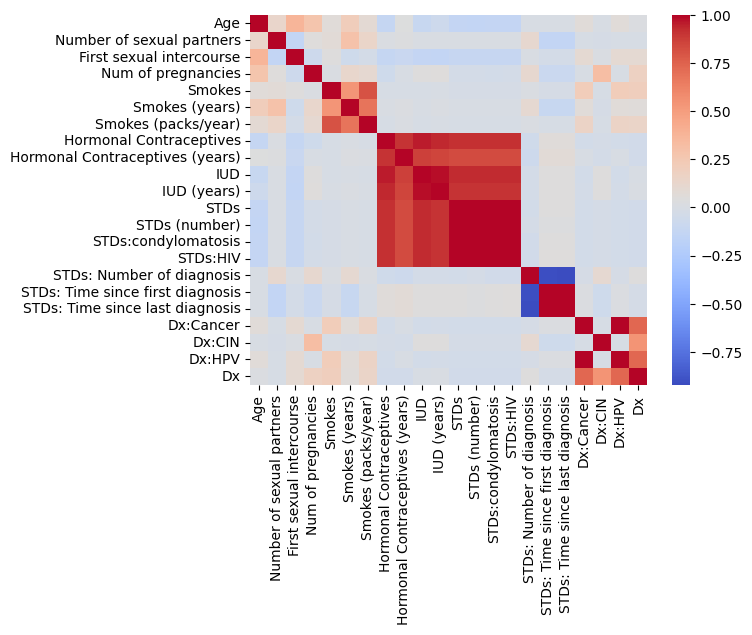

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify correlated features using correlation heatmap
sns.heatmap(df.corr(),cmap='coolwarm')


FEATURE EXTRACTION USING PCA

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) 
df = pca.fit_transform(df)
# df

<Axes: >

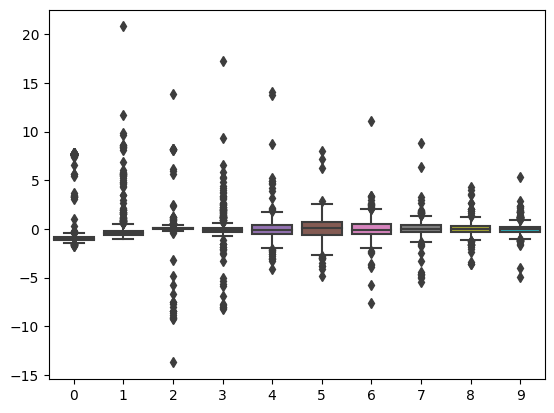

In [9]:

sns.boxplot(data=df)


<Axes: >

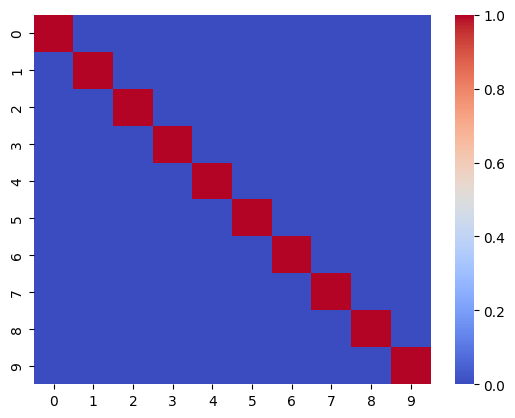

In [10]:
TEMP = pd.DataFrame(df)
sns.heatmap(TEMP.corr(),cmap='coolwarm')

Test Train split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_hinselmann_train, y_hinselmann_test = train_test_split(df, y_hinselmann, test_size=0.2, random_state=42)
X_train, X_test, y_schiller_train, y_schiller_test = train_test_split(df, y_schiller, test_size=0.2, random_state=42)
X_train, X_test, y_citology_train, y_citology_test = train_test_split(df, y_citology, test_size=0.2, random_state=42)
X_train, X_test, y_biopsy_train, y_biopsy_test = train_test_split(df, y_biopsy, test_size=0.2, random_state=42)

Data Balancing

In [12]:

from imblearn.over_sampling import ADASYN
ads = ADASYN(random_state=42)
X_train_hinselmann, y_hinselmann_train = ads.fit_resample(X_train, y_hinselmann_train)
X_train_schiller, y_schiller_train = ads.fit_resample(X_train, y_schiller_train)
X_train_citology, y_citology_train = ads.fit_resample(X_train, y_citology_train)
X_train_biopsy, y_biopsy_train = ads.fit_resample(X_train, y_biopsy_train)


IMPORTING LIBRARIES FOR SK-LEARN

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

SVM AND KNN CLASSIFIACTION FOR HINSELMANN TEST

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
FOR HINSELMANN:
SVM Classifier:
Accuracy: 0.8832116788321168
Precision: 0.14285714285714285
Recall: 0.3333333333333333
Confusion Matrix:
 [[119  12]
 [  4   2]]


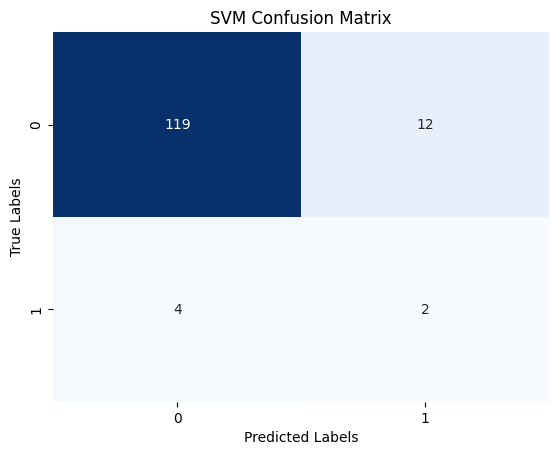

Tuned SVM Classifier:
Accuracy: 0.9124087591240876
Precision: 0.2
Recall: 0.3333333333333333
Confusion Matrix:
 [[123   8]
 [  4   2]]


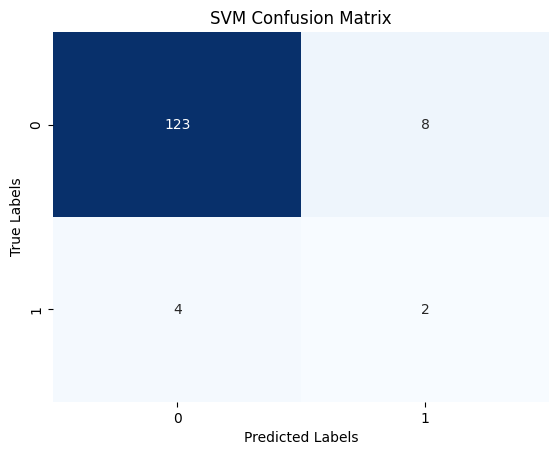

KNN Classifier:
Accuracy: 0.8540145985401459
Precision: 0.15
Recall: 0.5
Confusion Matrix:
 [[114  17]
 [  3   3]]


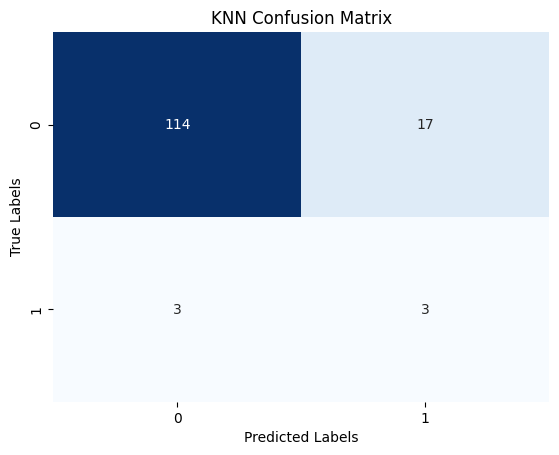

Tuned KNN Classifier:
Accuracy: 0.8759124087591241
Precision: 0.17647058823529413
Recall: 0.5
Confusion Matrix:
 [[117  14]
 [  3   3]]


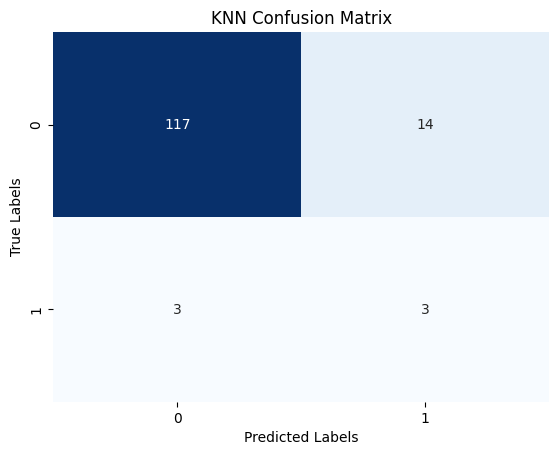

In [14]:
sc = StandardScaler()
X_train_hinselmann = sc.fit_transform(X_train_hinselmann)
X_test = sc.transform(X_test)

svm = SVC(kernel='rbf', C=1000, gamma='scale', random_state=42)
svm.fit(X_train_hinselmann, y_hinselmann_train)
svm_pred = svm.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_hinselmann, y_hinselmann_train)
knn_pred = knn.predict(X_test)

#TUNING
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, verbose=3, n_jobs=-1)
svm_grid.fit(X_train_hinselmann, y_hinselmann_train)
svm_tuned = svm_grid.best_estimator_
svm_tuned_pred = svm_tuned.predict(X_test)


knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, verbose=3, n_jobs=-1)
knn_grid.fit(X_train_hinselmann, y_hinselmann_train)
knn_tuned = knn_grid.best_estimator_
knn_tuned_pred = knn_tuned.predict(X_test)


#results

svm_accuracy = accuracy_score(y_hinselmann_test, svm_pred )
svm_precision = precision_score(y_hinselmann_test, svm_pred, average='binary')
svm_recall = recall_score(y_hinselmann_test, svm_pred, average='binary')
svm_cm = confusion_matrix(y_hinselmann_test, svm_pred)

svm_tuned_accuracy = accuracy_score(y_hinselmann_test, svm_tuned_pred)
svm_tuned_precision = precision_score(y_hinselmann_test, svm_tuned_pred, average='binary')
svm_tuned_recall = recall_score(y_hinselmann_test, svm_tuned_pred)
svm_tuned_cm = confusion_matrix(y_hinselmann_test, svm_tuned_pred)


knn_accuracy = accuracy_score(y_hinselmann_test, knn_pred)
knn_precision = precision_score(y_hinselmann_test, knn_pred, average='binary')
knn_recall = recall_score(y_hinselmann_test, knn_pred, average='binary')
knn_cm = confusion_matrix(y_hinselmann_test, knn_pred)

knn_tuned_accuracy = accuracy_score(y_hinselmann_test, knn_tuned_pred)
knn_tuned_precision = precision_score(y_hinselmann_test, knn_tuned_pred, average='binary')
knn_tuned_recall = recall_score(y_hinselmann_test, knn_tuned_pred, average='binary')
knn_tuned_cm = confusion_matrix(y_hinselmann_test, knn_tuned_pred)

print('FOR HINSELMANN:')
print('SVM Classifier:')
print('Accuracy:', svm_accuracy)
print('Precision:', svm_precision)
print('Recall:', svm_recall)
print('Confusion Matrix:\n', svm_cm)
sns.heatmap(svm_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('Tuned SVM Classifier:')
print('Accuracy:', svm_tuned_accuracy)
print('Precision:', svm_tuned_precision)
print('Recall:', svm_tuned_recall)
print('Confusion Matrix:\n',svm_tuned_cm)
sns.heatmap(svm_tuned_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('KNN Classifier:')
print('Accuracy:', knn_accuracy)
print('Precision:', knn_precision)
print('Recall:', knn_recall)
print('Confusion Matrix:\n', knn_cm)
sns.heatmap(knn_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('Tuned KNN Classifier:')
print('Accuracy:', knn_tuned_accuracy)
print('Precision:', knn_tuned_precision)
print('Recall:', knn_tuned_recall)
print('Confusion Matrix:\n',knn_tuned_cm)
sns.heatmap(knn_tuned_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

SVM AND KNN CLASSIFIACTION FOR SCHILLER TEST

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
FOR SCHILLER:
SVM Classifier:
Accuracy: 0.6934306569343066
Precision: 0.13953488372093023
Recall: 0.5454545454545454
Confusion Matrix:
 [[89 37]
 [ 5  6]]


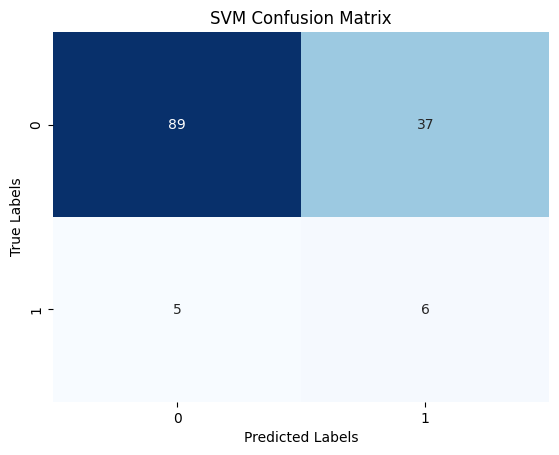

Tuned SVM Classifier:
Accuracy: 0.8394160583941606
Precision: 0.21052631578947367
Recall: 0.36363636363636365
Confusion Matrix:
 [[111  15]
 [  7   4]]


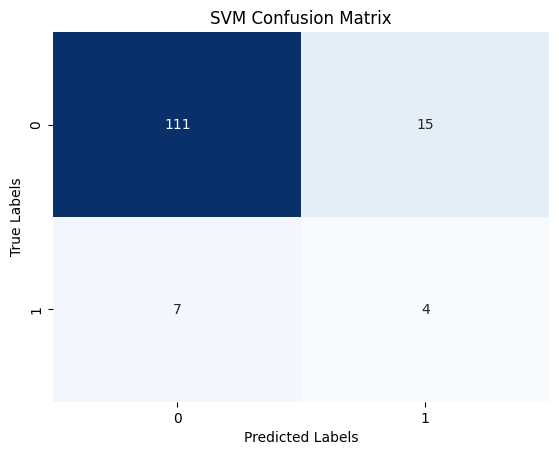

KNN Classifier:
Accuracy: 0.7591240875912408
Precision: 0.19444444444444445
Recall: 0.6363636363636364
Confusion Matrix:
 [[97 29]
 [ 4  7]]


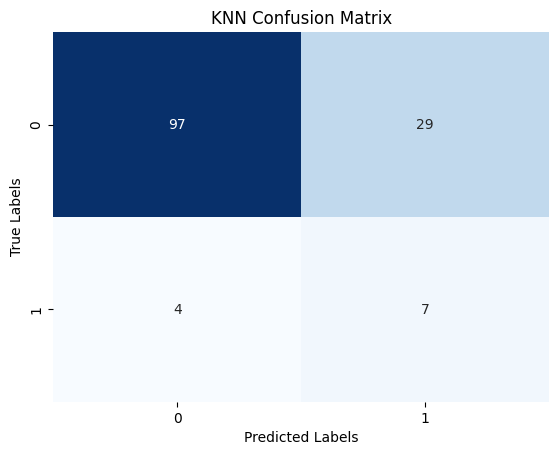

Tuned KNN Classifier:
Accuracy: 0.7664233576642335
Precision: 0.2
Recall: 0.6363636363636364
Confusion Matrix:
 [[98 28]
 [ 4  7]]


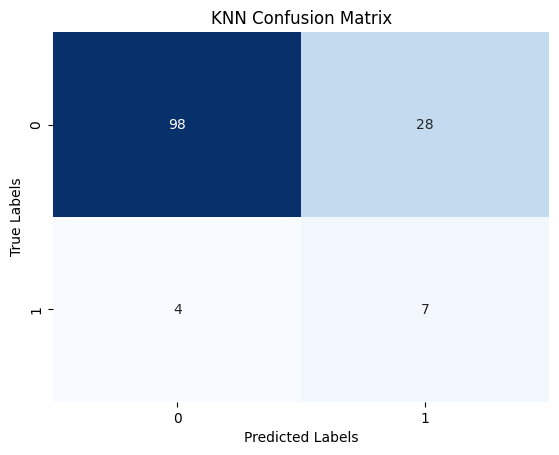

In [15]:
sc = StandardScaler()
X_train_schiller = sc.fit_transform(X_train_schiller)
X_test = sc.transform(X_test)

svm = SVC(kernel='rbf', C=1000, gamma='scale', random_state=42)
svm.fit(X_train_schiller, y_schiller_train)
svm_pred = svm.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_schiller, y_schiller_train)
knn_pred = knn.predict(X_test)

#TUNING
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, verbose=3, n_jobs=-1)
svm_grid.fit(X_train_schiller, y_schiller_train)
svm_tuned = svm_grid.best_estimator_
svm_tuned_pred = svm_tuned.predict(X_test)

knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, verbose=3, n_jobs=-1)
knn_grid.fit(X_train_schiller, y_schiller_train)
knn_tuned = knn_grid.best_estimator_
knn_tuned_pred = knn_tuned.predict(X_test)

#results
svm_accuracy = accuracy_score(y_schiller_test, svm_pred )
svm_precision = precision_score(y_schiller_test, svm_pred, average='binary')
svm_recall = recall_score(y_schiller_test, svm_pred, average='binary')
svm_cm = confusion_matrix(y_schiller_test, svm_pred)

svm_tuned_accuracy = accuracy_score(y_schiller_test, svm_tuned_pred)
svm_tuned_precision = precision_score(y_schiller_test, svm_tuned_pred, average='binary')
svm_tuned_recall = recall_score(y_schiller_test, svm_tuned_pred)
svm_tuned_cm = confusion_matrix(y_schiller_test, svm_tuned_pred)

knn_accuracy = accuracy_score(y_schiller_test, knn_pred)
knn_precision = precision_score(y_schiller_test, knn_pred, average='binary')
knn_recall = recall_score(y_schiller_test, knn_pred, average='binary')
knn_cm = confusion_matrix(y_schiller_test, knn_pred)

knn_tuned_accuracy = accuracy_score(y_schiller_test, knn_tuned_pred)
knn_tuned_precision = precision_score(y_schiller_test, knn_tuned_pred, average='binary')
knn_tuned_recall = recall_score(y_schiller_test, knn_tuned_pred, average='binary')
knn_tuned_cm = confusion_matrix(y_schiller_test, knn_tuned_pred)

print('FOR SCHILLER:')
print('SVM Classifier:')
print('Accuracy:', svm_accuracy)
print('Precision:', svm_precision)
print('Recall:', svm_recall)
print('Confusion Matrix:\n', svm_cm)
sns.heatmap(svm_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('Tuned SVM Classifier:')
print('Accuracy:', svm_tuned_accuracy)
print('Precision:', svm_tuned_precision)
print('Recall:', svm_tuned_recall)
print('Confusion Matrix:\n',svm_tuned_cm)
sns.heatmap(svm_tuned_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('KNN Classifier:')
print('Accuracy:', knn_accuracy)
print('Precision:', knn_precision)
print('Recall:', knn_recall)
print('Confusion Matrix:\n', knn_cm)
sns.heatmap(knn_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('Tuned KNN Classifier:')
print('Accuracy:', knn_tuned_accuracy)
print('Precision:', knn_tuned_precision)
print('Recall:', knn_tuned_recall)
print('Confusion Matrix:\n',knn_tuned_cm)
sns.heatmap(knn_tuned_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

SVM AND KNN CLASSIFIACTION FOR CITOLOGY TEST

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
FOR CITOLOGY:
SVM Classifier:
Accuracy: 0.708029197080292
Precision: 0.08333333333333333
Recall: 0.3
Confusion Matrix:
 [[94 33]
 [ 7  3]]


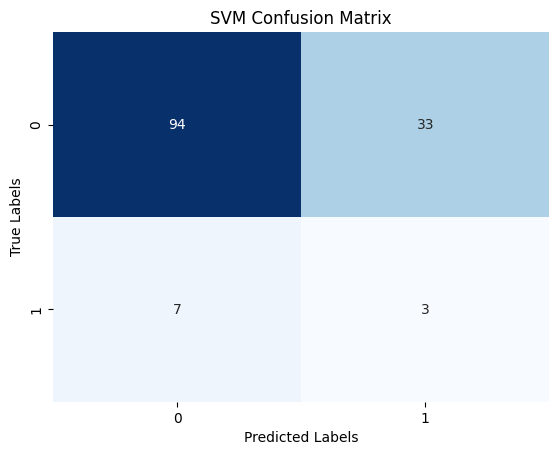

Tuned SVM Classifier:
Accuracy: 0.8467153284671532
Precision: 0.13333333333333333
Recall: 0.2
Confusion Matrix:
 [[114  13]
 [  8   2]]


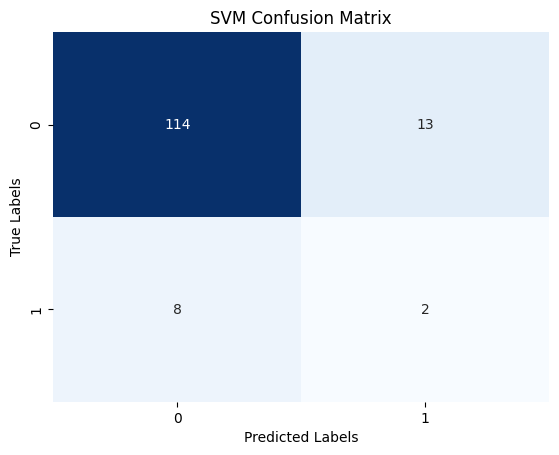

KNN Classifier:
Accuracy: 0.7007299270072993
Precision: 0.10256410256410256
Recall: 0.4
Confusion Matrix:
 [[92 35]
 [ 6  4]]


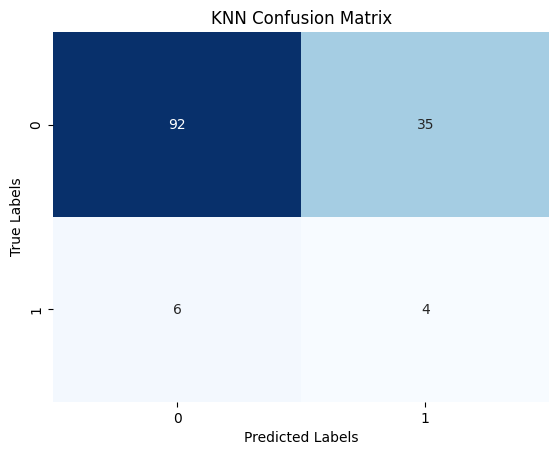

Tuned KNN Classifier:
Accuracy: 0.7445255474452555
Precision: 0.12121212121212122
Recall: 0.4
Confusion Matrix:
 [[98 29]
 [ 6  4]]


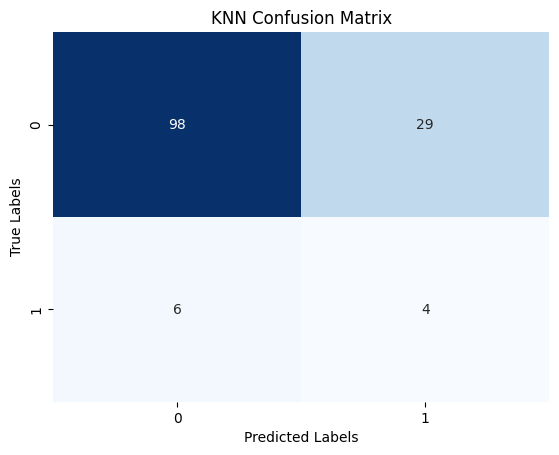

In [16]:
sc = StandardScaler()
X_train_citology = sc.fit_transform(X_train_citology)
X_test = sc.transform(X_test)

svm = SVC(kernel='rbf', C=1000, gamma='scale', random_state=42)
svm.fit(X_train_citology, y_citology_train)
svm_pred = svm.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_citology, y_citology_train)
knn_pred = knn.predict(X_test)

#TUNING
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, verbose=3, n_jobs=-1)
svm_grid.fit(X_train_citology, y_citology_train)
svm_tuned = svm_grid.best_estimator_
svm_tuned_pred = svm_tuned.predict(X_test)

knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, verbose=3, n_jobs=-1)
knn_grid.fit(X_train_citology, y_citology_train)
knn_tuned = knn_grid.best_estimator_
knn_tuned_pred = knn_tuned.predict(X_test)

#results
svm_accuracy = accuracy_score(y_citology_test, svm_pred )
svm_precision = precision_score(y_citology_test, svm_pred, average='binary')
svm_recall = recall_score(y_citology_test, svm_pred, average='binary')
svm_cm = confusion_matrix(y_citology_test, svm_pred)

svm_tuned_accuracy = accuracy_score(y_citology_test, svm_tuned_pred)
svm_tuned_precision = precision_score(y_citology_test, svm_tuned_pred, average='binary')
svm_tuned_recall = recall_score(y_citology_test, svm_tuned_pred)
svm_tuned_cm = confusion_matrix(y_citology_test, svm_tuned_pred)

knn_accuracy = accuracy_score(y_citology_test, knn_pred)
knn_precision = precision_score(y_citology_test, knn_pred, average='binary')
knn_recall = recall_score(y_citology_test, knn_pred, average='binary')
knn_cm = confusion_matrix(y_citology_test, knn_pred)

knn_tuned_accuracy = accuracy_score(y_citology_test, knn_tuned_pred)
knn_tuned_precision = precision_score(y_citology_test, knn_tuned_pred, average='binary')
knn_tuned_recall = recall_score(y_citology_test, knn_tuned_pred, average='binary')
knn_tuned_cm = confusion_matrix(y_citology_test, knn_tuned_pred)

print('FOR CITOLOGY:')
print('SVM Classifier:')
print('Accuracy:', svm_accuracy)
print('Precision:', svm_precision)
print('Recall:', svm_recall)
print('Confusion Matrix:\n', svm_cm)
sns.heatmap(svm_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('Tuned SVM Classifier:')
print('Accuracy:', svm_tuned_accuracy)
print('Precision:', svm_tuned_precision)
print('Recall:', svm_tuned_recall)
print('Confusion Matrix:\n',svm_tuned_cm)
sns.heatmap(svm_tuned_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('KNN Classifier:')
print('Accuracy:', knn_accuracy)
print('Precision:', knn_precision)
print('Recall:', knn_recall)
print('Confusion Matrix:\n', knn_cm)
sns.heatmap(knn_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('Tuned KNN Classifier:')
print('Accuracy:', knn_tuned_accuracy)
print('Precision:', knn_tuned_precision)
print('Recall:', knn_tuned_recall)
print('Confusion Matrix:\n',knn_tuned_cm)
sns.heatmap(knn_tuned_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

SVM AND KNN CLASSIFIACTION FOR BIOPSY TEST

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
FOR BIOPSY:
SVM Classifier:
Accuracy: 0.6423357664233577
Precision: 0.044444444444444446
Recall: 0.25
Confusion Matrix:
 [[86 43]
 [ 6  2]]


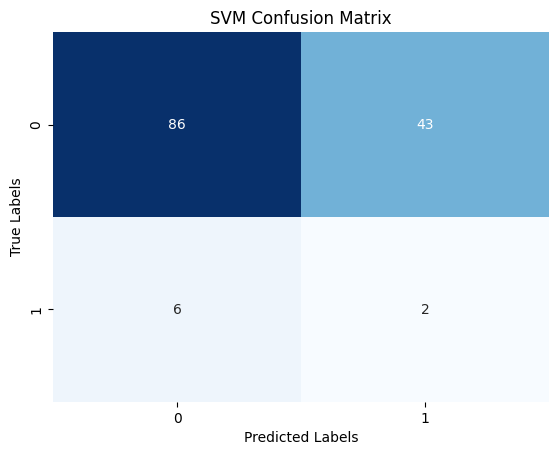

Tuned SVM Classifier:
Accuracy: 0.7445255474452555
Precision: 0.06451612903225806
Recall: 0.25
Confusion Matrix:
 [[100  29]
 [  6   2]]


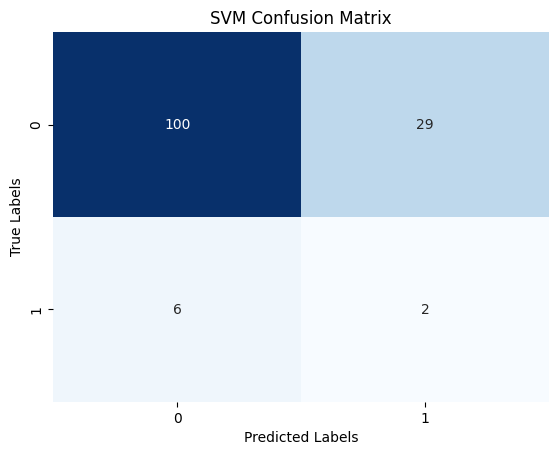

KNN Classifier:
Accuracy: 0.7445255474452555
Precision: 0.09090909090909091
Recall: 0.375
Confusion Matrix:
 [[99 30]
 [ 5  3]]


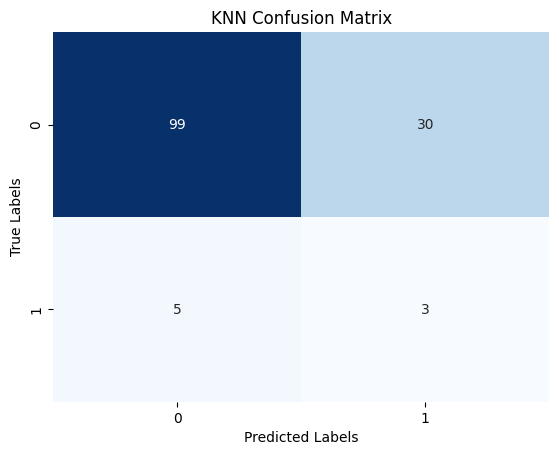

Tuned KNN Classifier:
Accuracy: 0.7518248175182481
Precision: 0.06666666666666667
Recall: 0.25
Confusion Matrix:
 [[101  28]
 [  6   2]]


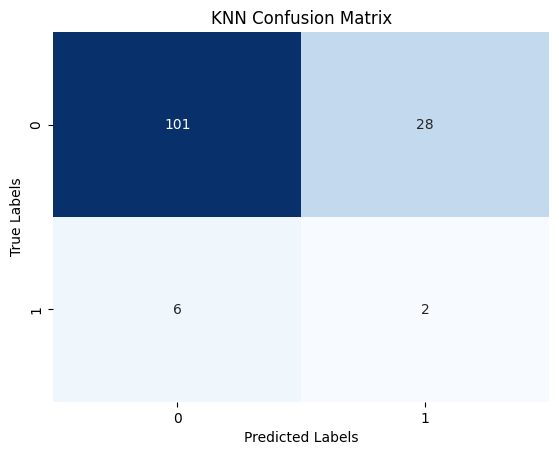

In [17]:
sc = StandardScaler()
X_train_biopsy = sc.fit_transform(X_train_biopsy)
X_test = sc.transform(X_test)

svm = SVC(kernel='poly', C=1000, gamma='scale', random_state=42)
svm.fit(X_train_biopsy, y_biopsy_train)
svm_pred = svm.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_biopsy, y_biopsy_train)
knn_pred = knn.predict(X_test)

#TUNING
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['poly']}
svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, verbose=3, n_jobs=-1)
svm_grid.fit(X_train_biopsy, y_biopsy_train)
svm_tuned = svm_grid.best_estimator_
svm_tuned_pred = svm_tuned.predict(X_test)

knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, verbose=3, n_jobs=-1)
knn_grid.fit(X_train_biopsy, y_biopsy_train)
knn_tuned = knn_grid.best_estimator_
knn_tuned_pred = knn_tuned.predict(X_test)

#results
svm_accuracy = accuracy_score(y_biopsy_test, svm_pred )
svm_precision = precision_score(y_biopsy_test, svm_pred, average='binary')
svm_recall = recall_score(y_biopsy_test, svm_pred, average='binary')
svm_cm = confusion_matrix(y_biopsy_test, svm_pred)

svm_tuned_accuracy = accuracy_score(y_biopsy_test, svm_tuned_pred)
svm_tuned_precision = precision_score(y_biopsy_test, svm_tuned_pred, average='binary')
svm_tuned_recall = recall_score(y_biopsy_test, svm_tuned_pred)
svm_tuned_cm = confusion_matrix(y_biopsy_test, svm_tuned_pred)

knn_accuracy = accuracy_score(y_biopsy_test, knn_pred)
knn_precision = precision_score(y_biopsy_test, knn_pred, average='binary')
knn_recall = recall_score(y_biopsy_test, knn_pred, average='binary')
knn_cm = confusion_matrix(y_biopsy_test, knn_pred)

knn_tuned_accuracy = accuracy_score(y_biopsy_test, knn_tuned_pred)
knn_tuned_precision = precision_score(y_biopsy_test, knn_tuned_pred, average='binary')
knn_tuned_recall = recall_score(y_biopsy_test, knn_tuned_pred, average='binary')
knn_tuned_cm = confusion_matrix(y_biopsy_test, knn_tuned_pred)

print('FOR BIOPSY:')
print('SVM Classifier:')
print('Accuracy:', svm_accuracy)
print('Precision:', svm_precision)
print('Recall:', svm_recall)
print('Confusion Matrix:\n', svm_cm)
sns.heatmap(svm_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('Tuned SVM Classifier:')
print('Accuracy:', svm_tuned_accuracy)
print('Precision:', svm_tuned_precision)
print('Recall:', svm_tuned_recall)
print('Confusion Matrix:\n',svm_tuned_cm)
sns.heatmap(svm_tuned_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('KNN Classifier:')
print('Accuracy:', knn_accuracy)
print('Precision:', knn_precision)
print('Recall:', knn_recall)
print('Confusion Matrix:\n', knn_cm)
sns.heatmap(knn_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('Tuned KNN Classifier:')
print('Accuracy:', knn_tuned_accuracy)
print('Precision:', knn_tuned_precision)
print('Recall:', knn_tuned_recall)
print('Confusion Matrix:\n',knn_tuned_cm)
sns.heatmap(knn_tuned_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()